In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tifffile
import matplotlib.pyplot as plt

File train.csv bao gồm các ID của ảnh, cùng với masks đã được mã hóa RLE. 

In [2]:
df = pd.read_csv('../input/hubmap-kidney-segmentation/train.csv')
print(df)
df.info()

          id                                           encoding
0  2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
1  aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
2  cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
3  0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
4  e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
5  095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
6  54f2eec69  124601765 36 124632133 109 124662536 147 12469...
7  1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8 non-null      object
 1   encoding  8 non-null      object
dtypes: object(2)
memory usage: 256.0+ bytes


Thông tin về dataset được sử dụng trong dự án.

In [3]:
df_info = pd.read_csv('../input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv')
df_info

image_file  width_pixels  height_pixels  \
0   afa5e8098.tiff         43780          36800   
1   54f2eec69.tiff         22240          30440   
2   1e2425f28.tiff         32220          26780   
3   e79de561c.tiff         27020          16180   
4   c68fe75ea.tiff         19780          26840   
5   095bf7a1f.tiff         39000          38160   
6   26dc41664.tiff         42360          38160   
7   aaa6a05cc.tiff         13013          18484   
8   b9a3865fc.tiff         40429          31295   
9   cb2d976f4.tiff         49548          34940   
10  b2dc8411c.tiff         31262          14844   
11  0486052bb.tiff         34937          25784   
12  2f6ecfcdf.tiff         25794          31278   

   anatomical_structures_segmention_file glomerulus_segmentation_file  \
0    afa5e8098-anatomical-structure.json               afa5e8098.json   
1    54f2eec69-anatomical-structure.json               54f2eec69.json   
2    1e2425f28-anatomical-structure.json               1e2425f28.json   
3    e79de561c-anatomical-structure.json               e79de561c.json   
4    c68fe75ea-anatomical-structure.json               c68fe75ea.json   
5    095bf7a1f-anatomical-structure.json               095bf7a1f.json   
6    26dc41664-anatomical-structure.json               26dc41664.json   
7    aaa6a05cc-anatomical-structure.json               aaa6a05cc.json   
8    b9a3865fc-anatomical-structure.json               b9a3865fc.json   
9    cb2d976f4-anatomical-structure.json               cb2d976f4.json   
10   b2dc8411c-anatomical-structure.json               b2dc8411c.json   
11   0486052bb-anatomical-structure.json               0486052bb.json   
12   2f6ecfcdf-anatomical-structure.json               2f6ecfcdf.json   

    patient_number                       race               ethnicity     sex  \
0            67347                      White  Not Hispanic or Latino  Female   
1            67548  Black or African American  Not Hispanic or Latino    Male   
2            63921                      White  Not Hispanic or Latino    Male   
3            67026  Black or African American  Not Hispanic or Latino    Male   
4            67112                      White  Not Hispanic or Latino    Male   
5            68250                      White  Not Hispanic or Latino  Female   
6            68304                      White  Not Hispanic or Latino  Female   
7            65631                      White  Not Hispanic or Latino  Female   
8            67347                      White  Not Hispanic or Latino  Female   
9            67548  Black or African American  Not Hispanic or Latino    Male   
10           67026  Black or African American  Not Hispanic or Latino    Male   
11           67177                      White  Not Hispanic or Latino    Male   
12           68555                      White  Not Hispanic or Latino  Female   

    age  weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
0    58              59.0               160.0        23.0      Right   
1    58              79.9               190.5        22.0      Right   
2    48             131.5               193.0        35.3      Right   
3    53              73.0               166.0        26.5       Left   
4    56              91.2               167.6        32.5       Left   
5    44              71.7               160.0        28.0      Right   
6    66              71.3               167.6        25.4       Left   
7    73               NaN                 NaN         NaN       Left   
8    58              59.0               160.0        23.0      Right   
9    58              79.9               190.5        22.0      Right   
10   53              73.0               166.0        26.5       Left   
11   31             106.1               180.3        32.6      Right   
12   76              93.0               157.4        37.5       Left   

    percent_cortex  percent_medulla  
0               55               45  
1               75               25  
2           

Kích thước của ảnh train.

In [4]:
print(df_info[['image_file', 'width_pixels', 'height_pixels']])

        image_file  width_pixels  height_pixels
0   afa5e8098.tiff         43780          36800
1   54f2eec69.tiff         22240          30440
2   1e2425f28.tiff         32220          26780
3   e79de561c.tiff         27020          16180
4   c68fe75ea.tiff         19780          26840
5   095bf7a1f.tiff         39000          38160
6   26dc41664.tiff         42360          38160
7   aaa6a05cc.tiff         13013          18484
8   b9a3865fc.tiff         40429          31295
9   cb2d976f4.tiff         49548          34940
10  b2dc8411c.tiff         31262          14844
11  0486052bb.tiff         34937          25784
12  2f6ecfcdf.tiff         25794          31278


In [5]:
os.makedirs('../output')
input_dir = '../input/hubmap-kidney-segmentation/train'
output_dir = '../output'
image_list = ['0486052bb', '2f6ecfcdf', 'aaa6a05cc']

In [6]:
def resize_im(im_name, scale_percent):
    image_path = os.path.join(input_dir, im_name+'.tiff')
    im_read = tifffile.imread(image_path)
    width = int(im_read.shape[1] * scale_percent / 100)
    height = int(im_read.shape[0] * scale_percent / 100)
    dim = (width, height)
    print('File name: {}, original size: {}, resized to: {}'.format(im_name, 
                                                                    (im_read.shape[0], im_read.shape[1]), 
                                                                    (width, height)))
    resized = cv2.resize(im_read, dim, interpolation=cv2.INTER_AREA)
    image_path = os.path.join(output_dir, ('r_' + im_name+'.tiff'))
    tifffile.imwrite(image_path, resized)

In [8]:
for img in image_list:
    resize_im(img, 5)

File name: 0486052bb, original size: (25784, 34937), resized to: (1746, 1289)
File name: 2f6ecfcdf, original size: (31278, 25794), resized to: (1289, 1563)
File name: aaa6a05cc, original size: (18484, 13013), resized to: (650, 924)


In [12]:
def rle2mask(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [13]:
def resize_mask(im_name, scale_percent):
    im_read = tifffile.imread(os.path.join(input_dir, im_name+'.tiff'))
    mask_rle = df[df["id"] == im_name]["encoding"].values[0]
    mask = rle2mask(df[df["id"] == im_name]["encoding"].values[0], (im_read.shape[1], im_read.shape[0]))*255
    width = int(im_read.shape[1] * scale_percent / 100)
    height = int(im_read.shape[0] * scale_percent / 100)
    dim = (width, height)
    print('File name: {}, original size: {}, resized to: {}'.format(im_name, 
                                                                (im_read.shape[0], im_read.shape[1]), 
                                                                (width, height)))
    resized = cv2.resize(mask, dim, interpolation=cv2.INTER_AREA)
    image_path = os.path.join(output_dir, ('r_' + im_name+'_m.tiff'))
    tifffile.imwrite(image_path, resized)

In [14]:
for img in image_list:
    resize_mask(img, 5)

File name: 0486052bb, original size: (25784, 34937), resized to: (1746, 1289)
File name: 2f6ecfcdf, original size: (31278, 25794), resized to: (1289, 1563)
File name: aaa6a05cc, original size: (18484, 13013), resized to: (650, 924)


In [15]:
os.listdir(output_dir)

['r_2f6ecfcdf_m.tiff',
 'r_0486052bb.tiff',
 'r_2f6ecfcdf.tiff',
 'r_aaa6a05cc_m.tiff',
 'r_0486052bb_m.tiff',
 'r_aaa6a05cc.tiff']

Show anh train

In [21]:
def show_image(image_id):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 32))
    image_path = os.path.join(output_dir, 'r_{}.tiff'.format(image_id))
    mask_path = os.path.join(output_dir, 'r_{}_m.tiff'.format(image_id))
    image = tifffile.imread(image_path)
    mask = tifffile.imread(mask_path)
    if len(mask.shape) == 2:
        hybr = image[:, :, 0] + mask[:, :]/2
    else:
        hybr = image[:, :, 0] + mask[:, :, 0]/2
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Real Image')
    ax[1].imshow(hybr)
    ax[1].axis('off')
    ax[1].set_title('Masks')
    plt.show()

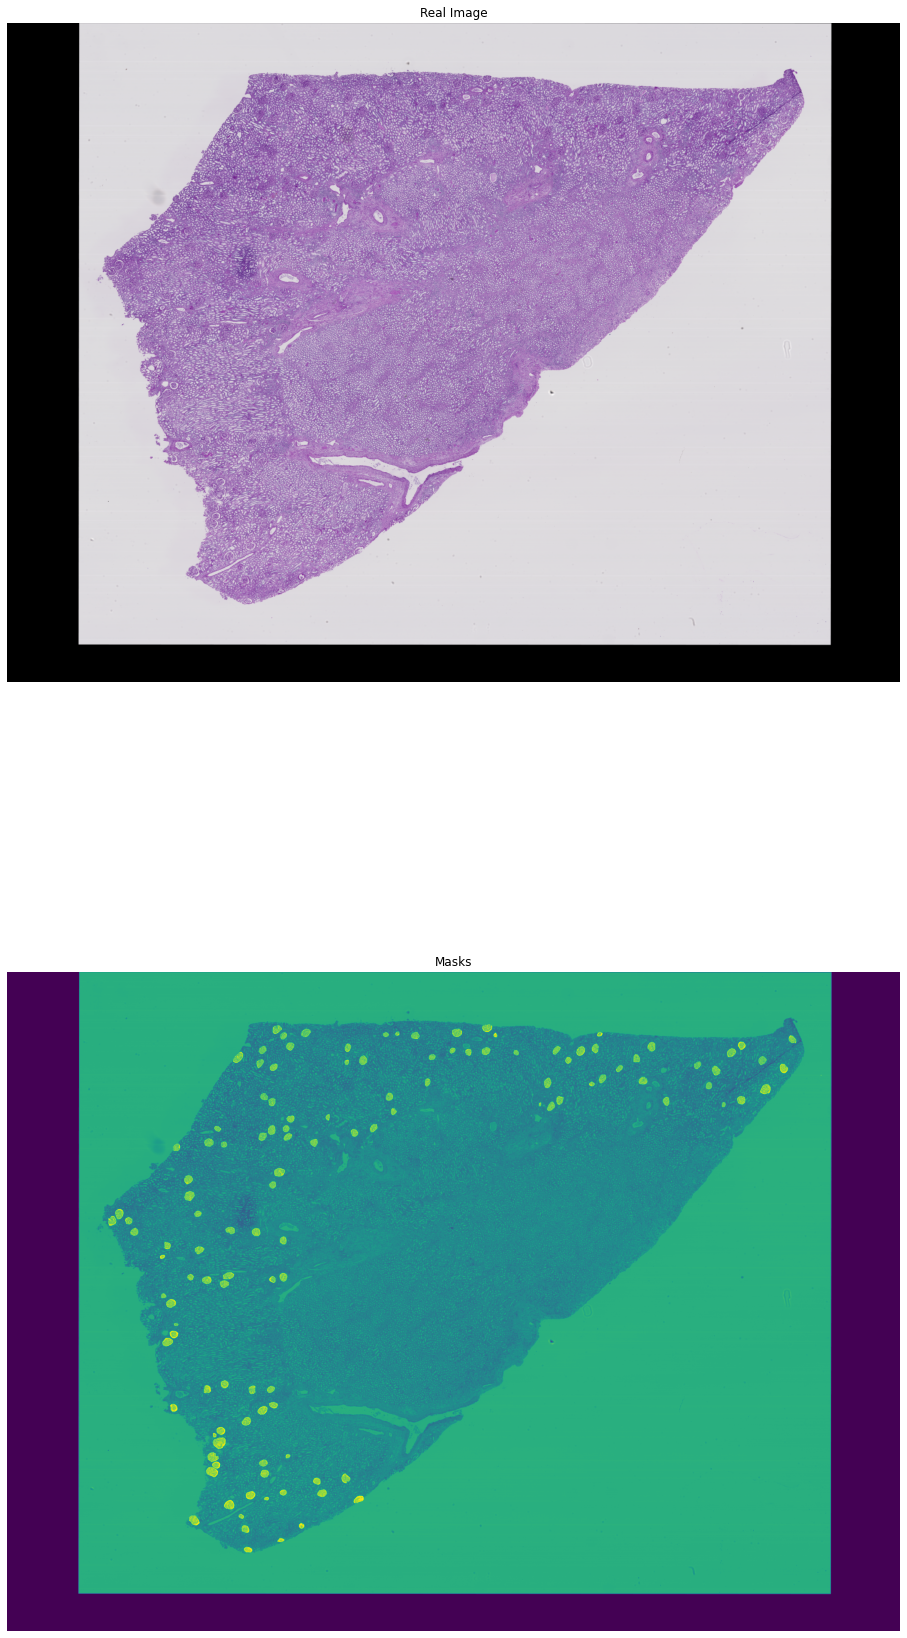

In [22]:
%matplotlib inline
show_image(image_list[0])

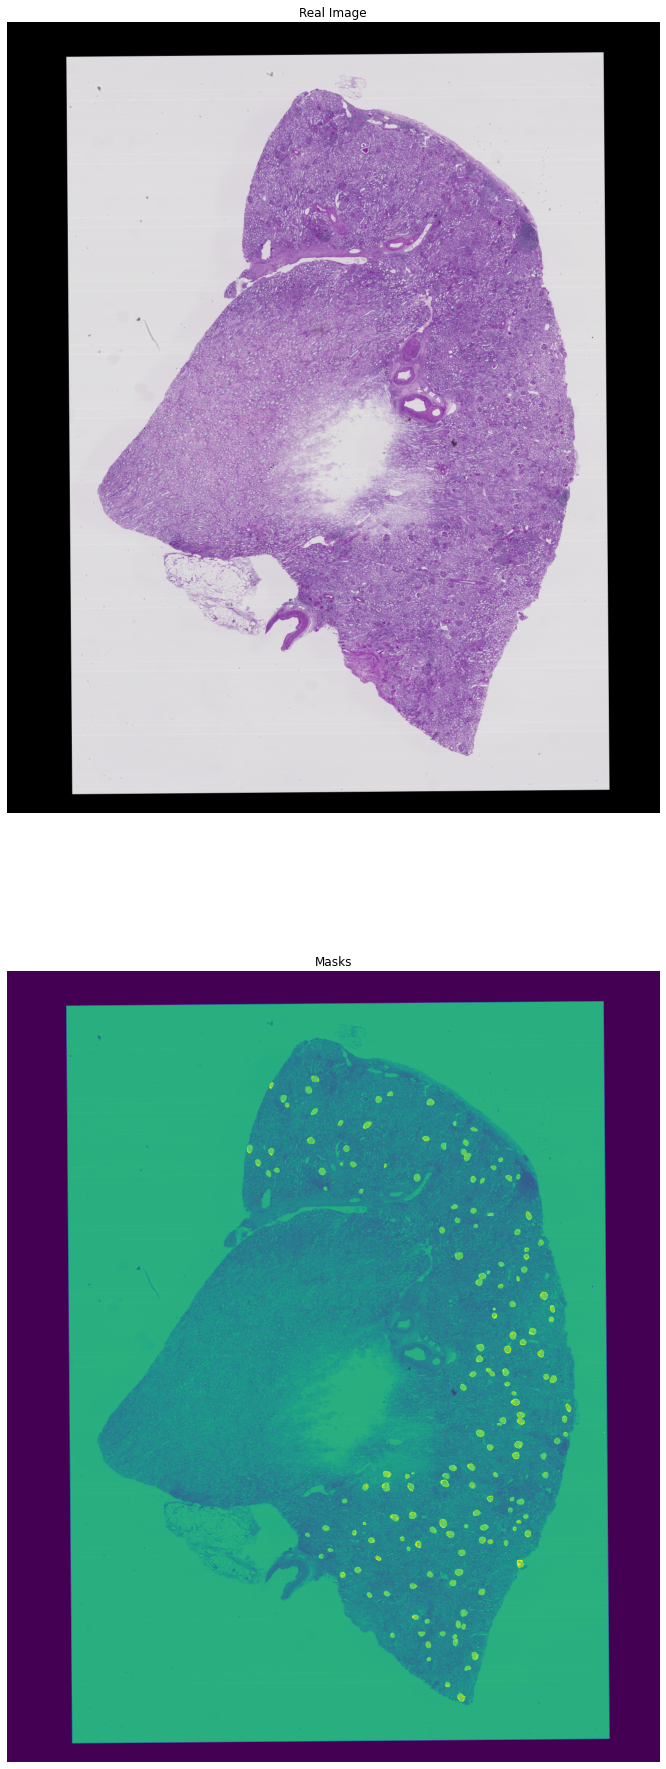

In [23]:
%matplotlib inline
show_image(image_list[1])

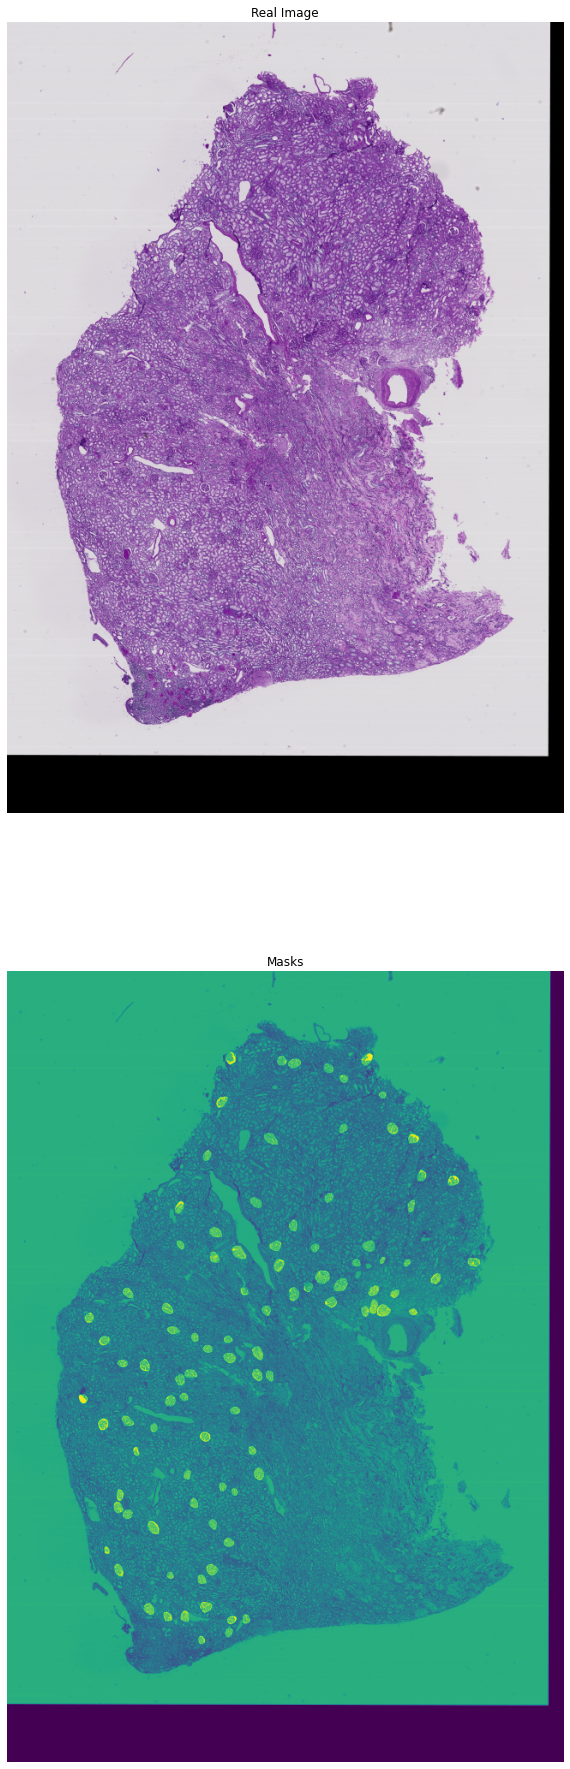

In [24]:
%matplotlib inline
show_image(image_list[2])

Do dữ liệu train là ảnh có kích thước rất lớn, nên ảnh train sẽ được chia nhỏ thành các ảnh nó có kích thước 256x256 hoặc 512x512 để có thể thực hiện huấn luyện model.

In [29]:
print(len(os.listdir('../input/hubmap-256x256/train')))
print(len(os.listdir('../input/hubmap-256x256/masks')))

3676
3676


In [30]:
mask_list = os.listdir('../input/hubmap-256x256/masks')
df = pd.DataFrame(index=mask_list)

In [31]:
def area_calc(image_id):
    mask_path = os.path.join(mask_dir, '{}'.format(image_id))
    mask = cv2.imread(mask_path)
    return int(np.count_nonzero(mask) / 3)

In [32]:
mask_dir = '../input/hubmap-256x256/masks'
mask_areas = []
for mask in mask_list:
    mask_areas.append(area_calc(mask))
df['area'] = mask_areas
print('Total: ', len(df))
print('Non-zero images: ', len(df[df['area']!=0]))

Total:  3676
Non-zero images:  1630


In [37]:
ids = pd.read_csv('../input/hubmap-kidney-segmentation/train.csv').id.values

In [38]:
ids

array(['2f6ecfcdf', 'aaa6a05cc', 'cb2d976f4', '0486052bb', 'e79de561c',
       '095bf7a1f', '54f2eec69', '1e2425f28'], dtype=object)

In [46]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
LABELS = '../input/hubmap-kidney-segmentation/train.csv'
MASKS = '../input/hubmap-256x256/masks'
TRAIN = '../input/hubmap-256x256/train'
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

from torch.utils.data import DataLoader, Dataset, sampler
def img2tensor(img, dtype:np.dtype=np.float32):
    if img.ndim==2: 
        img=np.expand_dims(img, 2)
    img=np.transpose(img, (2, 0, 1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self):
        ids = pd.read_csv(LABELS).id.values
        self.fnames=[fname for fname in os.listdir(TRAIN) if fname.split('_')[0] in ids]
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        imgs=cv2.cvtColor(cv2.imread(os.path.join(TRAIN, fname)), cv2.COLOR_BGR2RGB)
        masks=cv2.imread(os.path.join(MASKS, fname), cv2.IMREAD_GRAYSCALE)
        return img2tensor((imgs/255.0-mean)/std), img2tensor(masks)

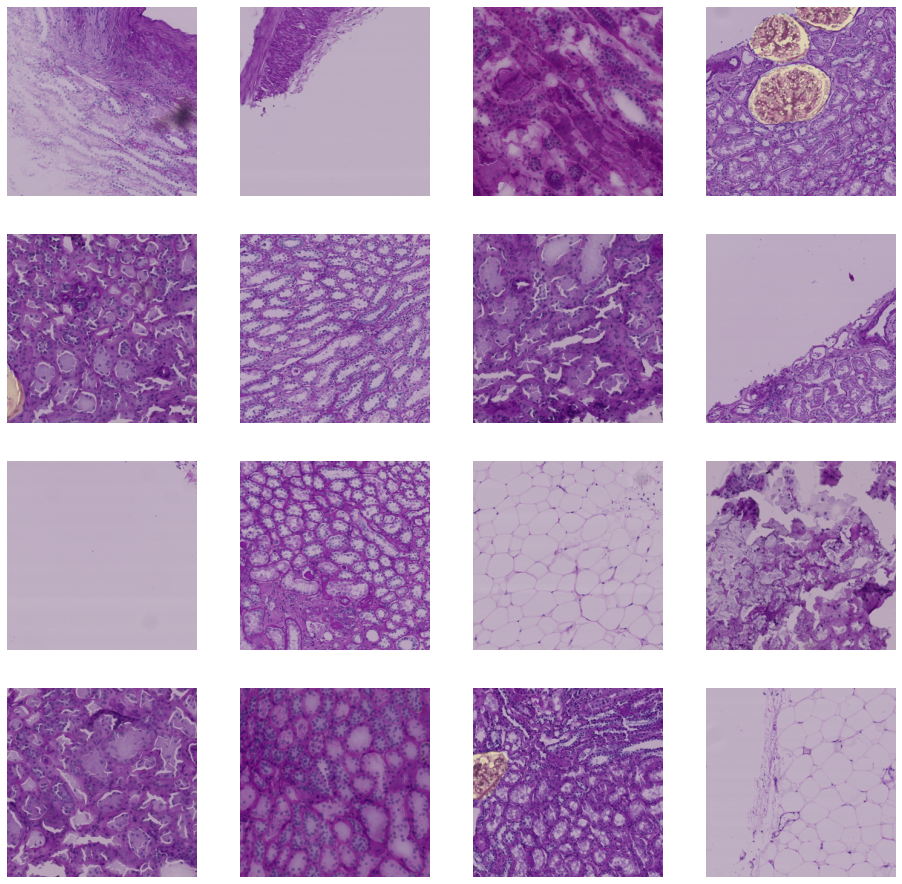

In [48]:
ds = HuBMAPDataset()
dl = DataLoader(ds, batch_size=16, shuffle=True, num_workers=4)
imgs, masks = next(iter(dl))
plt.figure(figsize=(16, 16))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img = ((img.permute(1, 2, 0)*std + mean) * 255.0).numpy().astype(np.uint8)
    plt.subplot(4, 4, i+1)
    plt.imshow(img, vmin=0, vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

del ds, dl, imgs, masks

Metadata EDA

In [68]:
import json
import seaborn as sns
import gc

# usefull functions

def js2df(path):
    '''
    Convert json to DataFrame
    '''
    with open(path) as f:
        data = json.load(f)
    return pd.DataFrame(data)

def shoelace_formula(mat):
    '''
    Formula for find area of polygon, mat is matrix with coords of size [Ncoords, 2]
    '''
    m = mat.squeeze()
    sum1 = np.sum(m[:-1, 0] * m[1:, 1]) + m[-1, 0] * m[0, 1] 
    sum2 = np.sum(m[1:, 0] * m[:-1, 1]) + m[0, 0] * m[-1, 1]
    return np.abs(sum1 - sum2) / 2

def open_img(path):
    '''
    Open .tiff image
    '''
    image = np.array(tifffile.imread(path))
    if image.ndim != 3:
        image = np.squeeze(image).transpose(1, 2, 0)
    return image

def rescale_img(image, scale=1):
    '''
    Rescale image
    '''
    dim = (int(image.shape[1]*scale), int(image.shape[0]*scale))
    image = cv2.resize(image, dim)
    return image

def mask_img(image, mask_list, scale=1, rgbcolor=(70, 255, 0), imgw=0.4, maskw=1):
    '''
    Masking image using list of polygons(mask)
    '''
    mask_polygons = [(i*scale).astype(int) for i in mask_list]
    mask = np.zeros(image.shape, dtype=np.uint8)
    mask = cv2.fillPoly(mask, mask_polygons, color=rgbcolor)
    return cv2.addWeighted(image, imgw, mask, maskw, 0)

def zoom_img(img, pos1, pos2, scale=1):
    '''
    Return rectangle pf image with coords in pos1(start position), pos2(end position)
    '''
    x1, y1 = int(pos1[0]*scale), int(pos1[1]*scale)
    x2, y2 = int(pos2[0]*scale), int(pos2[1]*scale)
    return img[y1:y2, x1:x2, :]

def my_style_ax(ax, title='', xlabel='', ylabel='', tfontsize=15, ylfontsize=18):
    ax.set_title(title, fontsize=tfontsize)
    ax.get_yaxis().set_ticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, rotation=0, labelpad=45, fontsize=ylfontsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

def preproccess_traindf(traincsv_path, infocsv_path, train_path):
    '''
    Preprocess train dataframe, for train add following data:
        anatomical_structures_segmention_geometry(dict with coordinates of polygons of cortex/medulla segments)
        kidney_bbox(kidney bounding box)
        glomerulus_coords(list of glom. coordinates)
        glom_num(number of glomerulus cells)
        avg_g_area(average area of glom. cell in pixels)
        glor_cells_on_pix(the content of the pixels of the cells of the cell on one pixel of the cortex)
    '''
    # get train dfs, train names
    train_names = [i + '.tiff' for i in list(pd.read_csv(traincsv_path)['id'])]
    df_info = pd.read_csv(infocsv_path)
    df_train = df_info[df_info['image_file'].isin(train_names)].reset_index(drop=True)
    objects_num = len(df_train)

    # new columns: anatomical geometry(cortex and etc.), kidney bbox
    anat_struct_res = []
    kidney_bbox_res = []
    kidney_area_res = []
    for i in range(objects_num):
        # anatomical coords
        df_anatom = js2df(train_path + df_train['anatomical_structures_segmention_file'][i])
        geometry = dict()
        for j in range(len(df_anatom)):
            name = df_anatom['properties'][j]['classification']['name']
            coords = np.array(df_anatom['geometry'][j]['coordinates'])
            if coords.ndim == 2:
                nnum = 0
                for nnum in range(len(coords)):
                    geometry[name + str(nnum)] = np.array([coords[nnum][0]])
            else:         
                geometry[name] = coords
        anat_struct_res.append(geometry)
        # get kidney bbox
        acords = np.hstack(list(geometry.values())).squeeze()
        kidney_bbox_res.append([np.min(acords[:, 0]), np.min(acords[:, 1]), np.max(acords[:, 0]), np.max(acords[:, 1])])
        # kidney area
        kidney_area = 0
        for k, v in geometry.items():
            if 'cortex' in str(k).lower():
                kidney_area += shoelace_formula(v)
        kidney_area_res.append(kidney_area)
    # add in dataframe
    df_train['anatomical_structures_segmention_geometry'] = anat_struct_res
    df_train['kidney_bbox'] = kidney_bbox_res
    df_train['kidney_area'] = kidney_area_res

    # new columns: glomerulus_coords, glom_num, avg_g_area
    glom_coords_res = []
    glom_num_res = []
    avg_g_area_res = []
    for i in range(objects_num):
        # glomerulus cells coordinates                                                                          
        df_glom = js2df(train_path + df_train['glomerulus_segmentation_file'][i])
        glomerulus_coords = []
        g_area = 0
        for k in range(len(df_glom)):
            g_coords = np.array(df_glom['geometry'][k]['coordinates'])
            g_area += shoelace_formula(g_coords)
            glomerulus_coords.append(g_coords)
        glom_coords_res.append(glomerulus_coords)
        # number of glomeruluses
        glom_num_res.append(len(df_glom))
        # average size of glomeruluses cells
        avg_g_area_res.append(g_area / len(df_glom))
    # add in dataframe
    df_train['glomerulus_coords'] = glom_coords_res
    df_train['glom_num'] = glom_num_res
    df_train['avg_g_area'] = avg_g_area_res
    df_train['glor_cells_on_pix'] = df_train['glom_num']*df_train['avg_g_area'] / df_train['kidney_area'] 

    del df_info, train_names, anat_struct_res, kidney_bbox_res, glom_coords_res, glom_num_res, 
    avg_g_area_res, kidney_area_res
    gc.collect()
    return df_train  


def preproccess_testdf(traincsv_path, infocsv_path, test_path):
    '''
    Preprocess train dataframe, for train add following data:
        anatomical_structures_segmention_geometry(dict with coordinates of polygons of cortex/medulla)
        kidney_bbox(kidney bounding box)
    '''
    # get test dfs, train names
    train_names = [i + '.tiff' for i in list(pd.read_csv(traincsv_path)['id'])]
    df_info = pd.read_csv(infocsv_path)
    df_test = df_info[~df_info['image_file'].isin(train_names)].reset_index(drop=True)
    objects_num = len(df_test)

    # new columns: anatomical geometry(cortex and etc.), kidney bbox
    anat_struct_res = []
    kidney_bbox_res = []
    for i in range(objects_num):
        # anatomical coords
        df_anatom = js2df(test_path + df_test['anatomical_structures_segmention_file'][i])
        geometry = dict()
        for j in range(len(df_anatom)):
            name = df_anatom['properties'][j]['classification']['name']
            coords = np.array(df_anatom['geometry'][j]['coordinates'])
            if coords.ndim == 2:
                nnum = 0
                for nnum in range(len(coords)):
                    geometry[name + str(nnum)] = np.array([coords[nnum][0]])
            else:         
                geometry[name] = coords
        anat_struct_res.append(geometry)
        # get kidney bbox
        acords = np.hstack(list(geometry.values())).squeeze()
        kidney_bbox_res.append([np.min(acords[:, 0]), np.min(acords[:, 1]), np.max(acords[:, 0]), np.max(acords[:, 1])])
    # add in dataframe
    df_test['anatomical_structures_segmention_geometry'] = anat_struct_res
    df_test['kidney_bbox'] = kidney_bbox_res 

    del df_info, train_names, anat_struct_res, kidney_bbox_res
    gc.collect()
    return df_test

In [69]:
TRAIN_CSV = '../input/hubmap-kidney-segmentation/train.csv'
INFO_CSV  = '../input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv'
TRAIN = '../input/hubmap-kidney-segmentation/train/'
TEST = '../input/hubmap-kidney-segmentation/test/'

In [70]:
df_train = pd.read_csv('../input/hubmap-kidney-segmentation/train.csv')
df_info = pd.read_csv('../input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv')

In [71]:
# get preprocessed datasets
df_train = preproccess_traindf(TRAIN_CSV, INFO_CSV, TRAIN)
df_test = preproccess_testdf(TRAIN_CSV, INFO_CSV, TEST)

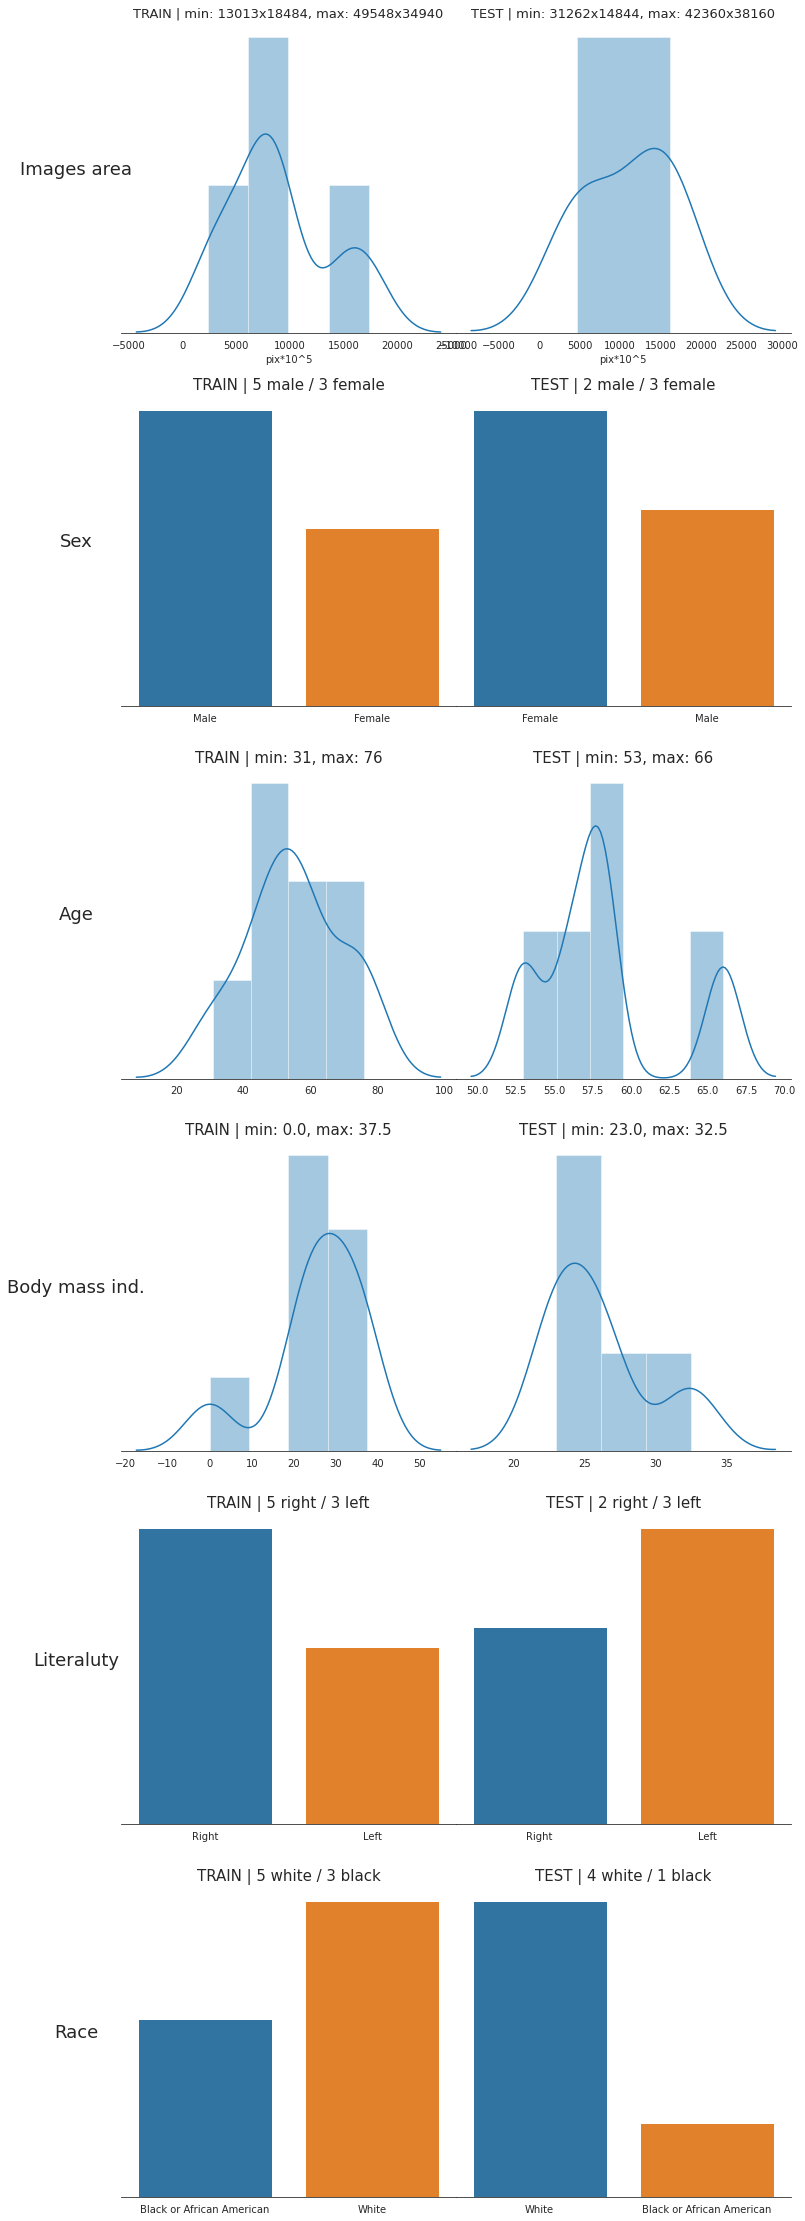

In [72]:
# metadata EDA
# average area of kidney
sns.set_style("white")
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(12, 40))
fig.subplots_adjust(wspace=0)

# mean image area
train_areas = df_train['width_pixels'] * df_train['height_pixels'] / 10**5
train_area_min = str(df_train['width_pixels'][np.argmin(train_areas)]) + 'x' + str(df_train['height_pixels'][np.argmin(train_areas)])
train_area_max = str(df_train['width_pixels'][np.argmax(train_areas)]) + 'x' + str(df_train['height_pixels'][np.argmax(train_areas)])
sns.distplot(train_areas, ax=ax[0][0])
my_style_ax(
    ax[0][0],
    title=f"TRAIN | min: {train_area_min}, max: {train_area_max}",
    xlabel="pix*10^5",
    ylabel='Images area',
    tfontsize=13
)
test_areas = df_test['width_pixels'] * df_test['height_pixels'] / 10**5 
test_area_min = str(df_test['width_pixels'][np.argmin(test_areas)]) + 'x' + str(df_test['height_pixels'][np.argmin(test_areas)])
test_area_max = str(df_test['width_pixels'][np.argmax(test_areas)]) + 'x' + str(df_test['height_pixels'][np.argmax(test_areas)])
sns.distplot(test_areas, ax=ax[0][1])
my_style_ax(
    ax[0][1],
    title=f"TEST | min: {test_area_min}, max: {test_area_max}",
    xlabel="pix*10^5",
    tfontsize=13
)

# sex
train_sex = df_train['sex']
sns.countplot(train_sex, ax=ax[1][0])
my_style_ax(
    ax[1][0],
    title=f"TRAIN | {train_sex.value_counts()['Male']} male / {train_sex.value_counts()['Female']} female",
    ylabel='Sex'
)
test_sex = df_test['sex']
sns.countplot(test_sex, ax=ax[1][1])
my_style_ax(
    ax[1][1],
    title=f"TEST | {test_sex.value_counts()['Male']} male / {test_sex.value_counts()['Female']} female"
)

# age
train_age = df_train['age']
sns.distplot(train_age, ax=ax[2][0])
my_style_ax(
    ax[2][0],
    title=f"TRAIN | min: {train_age.min()}, max: {train_age.max()}",
    ylabel="Age"
)
test_age = df_test['age']
sns.distplot(test_age, ax=ax[2][1])
my_style_ax(
    ax[2][1],
    title=f"TEST | min: {test_age.min()}, max: {test_age.max()}"
)

# Body mass index
train_bmi = df_train['bmi_kg/m^2'].fillna(0)
sns.distplot(train_bmi, ax=ax[3][0])
my_style_ax(
    ax[3][0],
    title=f"TRAIN | min: {train_bmi.min()}, max: {train_bmi.max()}",
    ylabel="Body mass ind."
)
test_bmi = df_test['bmi_kg/m^2'].fillna(0)
sns.distplot(test_bmi, ax=ax[3][1])
my_style_ax(
    ax[3][1],
    title=f"TEST | min: {test_bmi.min()}, max: {test_bmi.max()}"
)

# literality
train_lit = df_train['laterality']
sns.countplot(train_lit, ax=ax[4][0])
my_style_ax(
    ax[4][0],
    title=f"TRAIN | {train_lit.value_counts()['Right']} right / {train_lit.value_counts()['Left']} left",
    ylabel='Literaluty'
)
test_lit = df_test['laterality']
sns.countplot(test_lit, ax=ax[4][1])
my_style_ax(
    ax[4][1],
    title=f"TEST | {test_lit.value_counts()['Right']} right / {test_lit.value_counts()['Left']} left"
)

# race
train_r = df_train['race']
sns.countplot(train_r, ax=ax[5][0])
my_style_ax(
    ax[5][0],
    title=f"TRAIN | {train_r.value_counts()['White']} white / {train_r.value_counts()['Black or African American']} black",
    ylabel='Race'
)
test_r = df_test['race']
sns.countplot(test_r, ax=ax[5][1])
my_style_ax(
    ax[5][1],
    title=f"TEST | {test_r.value_counts()['White']} white / {test_r.value_counts()['Black or African American']} black"
)

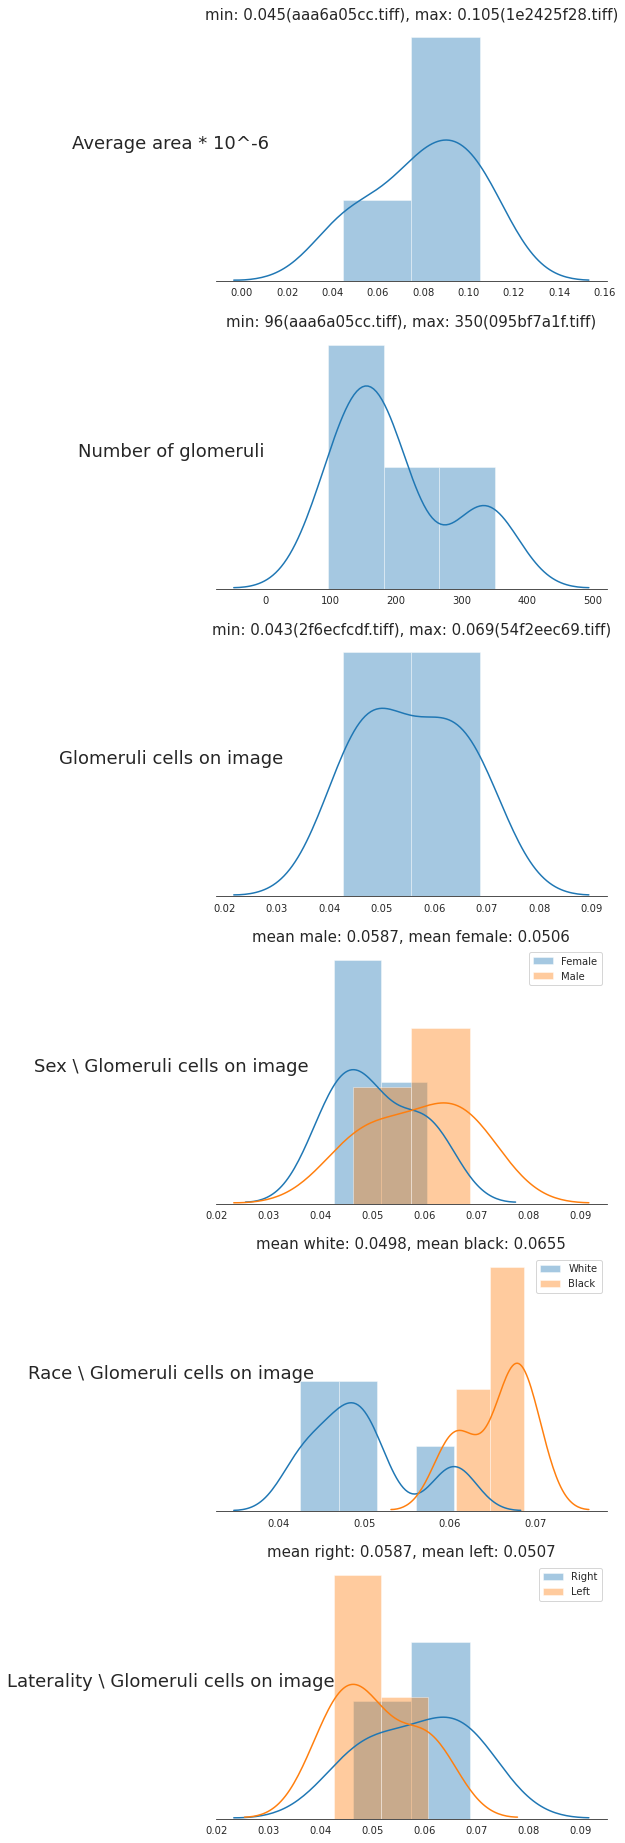

In [73]:
_, axs = plt.subplots(nrows=6, ncols=1, figsize=(7, 33))
axs = axs.flatten()

# gl. avg area
gl_avg = df_train['avg_g_area'] / 10**6
gl_avg_min_ind, gl_avg_max_ind = np.argmin(gl_avg), np.argmax(gl_avg)
sns.distplot(gl_avg, ax=axs[0])
my_style_ax(
    axs[0],
    title=f"min: {np.round(gl_avg[gl_avg_min_ind], 3)}({df_train['image_file'][gl_avg_min_ind]}), "
          f"max: {np.round(gl_avg[gl_avg_max_ind], 3)}({df_train['image_file'][gl_avg_max_ind]})",
    ylabel='Average area * 10^-6'
)
# gl. count
gl_count = df_train['glom_num']
gl_count_min_ind, gl_count_max_ind = np.argmin(gl_count), np.argmax(gl_count)
sns.distplot(gl_count, ax=axs[1])
my_style_ax(
    axs[1],
    title=f"min: {np.round(gl_count[gl_count_min_ind], 3)}({df_train['image_file'][gl_count_min_ind]}), "
          f"max: {np.round(gl_count[gl_count_max_ind], 3)}({df_train['image_file'][gl_count_max_ind]})",
    ylabel='Number of glomeruli'
)
# gl. content on cortex pixels
gl_cp = df_train['glor_cells_on_pix']
gl_cp_min_ind, gl_cp_max_ind = np.argmin(gl_cp), np.argmax(gl_cp)
sns.distplot(gl_cp, ax=axs[2])
my_style_ax(
    axs[2],
    title=f"min: {np.round(gl_cp[gl_cp_min_ind], 3)}({df_train['image_file'][gl_cp_min_ind]}), "
          f"max: {np.round(gl_cp[gl_cp_max_ind], 3)}({df_train['image_file'][gl_cp_max_ind]})",
    ylabel='Glomeruli cells on image'
)
# sex
fem = df_train[df_train['sex'] == 'Female']['glor_cells_on_pix']
male = df_train[df_train['sex'] == 'Male']['glor_cells_on_pix']
sns.distplot(fem, ax=axs[3], label='Female')
sns.distplot(male, ax=axs[3], label='Male')
my_style_ax(axs[3], 
            title=f'mean male: {round(male.mean(), 4)}, mean female: {round(fem.mean(), 4)}',
            ylabel='Sex \ Glomeruli cells on image'
           )
axs[3].legend()
# race
rw = df_train[df_train['race'] == 'White']['glor_cells_on_pix']
rb = df_train[df_train['race'] != 'White']['glor_cells_on_pix']
sns.distplot(rw, ax=axs[4], label='White')
sns.distplot(rb, ax=axs[4], label='Black')
my_style_ax(
    axs[4],
    title=f'mean white: {round(rw.mean(), 4)}, mean black: {round(rb.mean(), 4)}',
    ylabel='Race \ Glomeruli cells on image'
)
axs[4].legend()
# laterality
lr = df_train[df_train['laterality'] == 'Right']['glor_cells_on_pix']
ll = df_train[df_train['laterality'] == 'Left']['glor_cells_on_pix']
sns.distplot(lr, ax=axs[5], label='Right')
sns.distplot(ll, ax=axs[5], label='Left')
my_style_ax(
    axs[5],
    title=f'mean right: {round(lr.mean(), 4)}, mean left: {round(ll.mean(), 4)}',
    ylabel='Laterality \ Glomeruli cells on image'
)
axs[5].legend()